<H1>Лабораторная работа №6</H1>

<H3>Ким Д.А. 5130901/10201</H3>

<H3>Упражнение 6.1</H3>
Убедимся, что analyze1 требует пропорционально n<sup>3</sup>, а analyze2 пропорционально n<sup>2</sup> с помощью нескольких примеров.

In [1]:
import thinkdsp
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
signal = thinkdsp.UncorrelatedUniformNoise()
noise = signal.make_wave(duration=2)

In [3]:
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_res(ns, bests):    
    plt.plot(ns, bests)
    thinkdsp.decorate(**loglog)
    
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

In [4]:
PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    """Analyze a mixture of cosines and return amplitudes.

    Works for the general case where M is not orthogonal.

    ys: wave array
    fs: frequencies in Hz
    ts: times where the signal was evaluated    

    returns: vector of amplitudes
    """
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

In [5]:
def analyze2(ys, fs, ts):
    """Analyze a mixture of cosines and return amplitudes.

    Assumes that fs and ts are chosen so that M is orthogonal.

    ys: wave array
    fs: frequencies in Hz
    ts: times where the signal was evaluated    

    returns: vector of amplitudes
    """
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

In [6]:
def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)
        
    bests = [result.best for result in results]
    return bests

In [7]:
ns = 2 ** np.arange(6, 13)
bests1 = run_speed_test(ns, analyze1)
bests2 = run_speed_test(ns, analyze2)

64
2.68 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
128
5.09 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
256
20.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
23.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
1024
39.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
147 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
541 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
64
39.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
200 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
256
479 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
2.78 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
10.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2048
39.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
156 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops 

1.2003653557992628

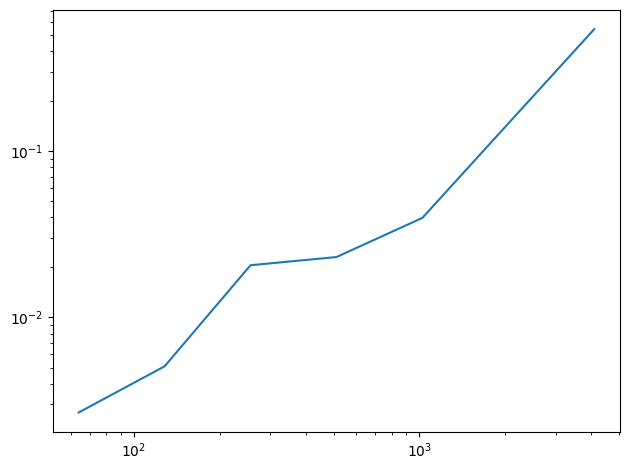

In [8]:
plot_res(ns, bests1)

1.9823005836897434

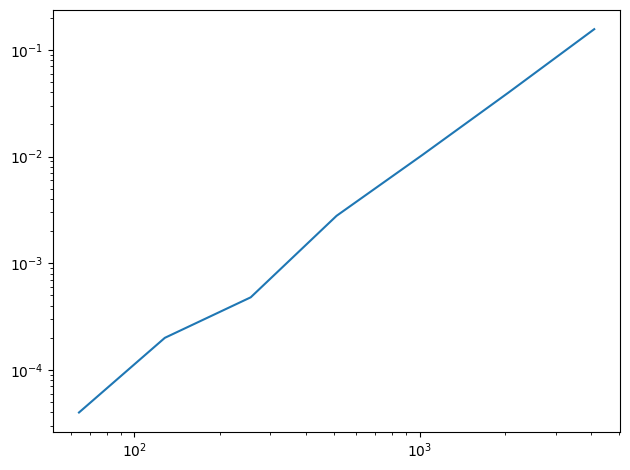

In [9]:
plot_res(ns, bests2)

Как можно видеть, analyze2 гораздо ближе к прямой чем analyze1. Воспользуемся scipy.fftpack.dct для реализации analyze.

64
3.76 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
128
4.23 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
256
4.16 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
512
5.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
1024
6.75 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
2048
10.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
4096
19.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)


0.3766696050124896

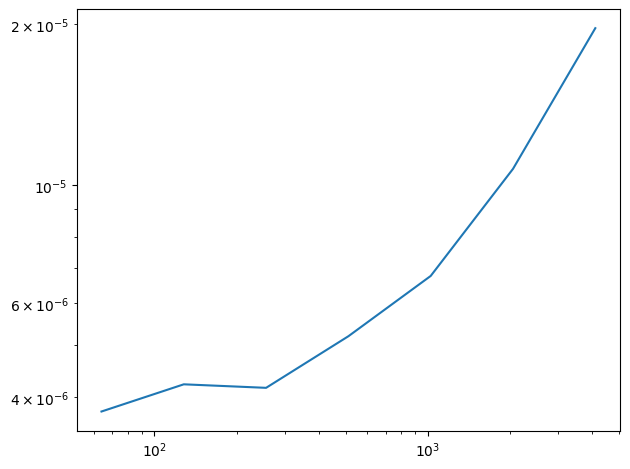

In [10]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)
bests3 = run_speed_test(ns, scipy_dct)
plot_res(ns, bests3)

Видим, что эта версия алгоритма работает еще быстрее.

<H3>Упражнение 6.2</H3>

Сделаем реализацию алгоритма, использующего ДКП для сжатия звука и протестируем его.

In [11]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

In [12]:
wave = thinkdsp.read_wave('../code/100475__iluppai__saxophone-weep.wav')
saxSegment = wave.segment(start=2, duration=0.5)
saxSegment.normalize()
saxSegment.make_audio()

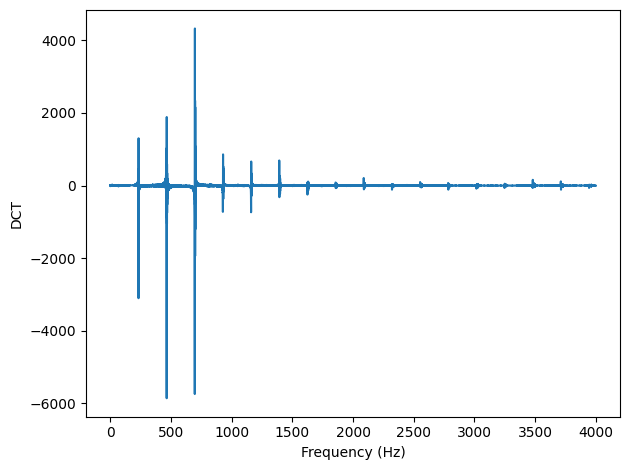

In [20]:
seg_dct = saxSegment.make_dct()
seg_dct.plot(high=4000)
thinkdsp.decorate(xlabel='Frequency (Hz)', ylabel='DCT')

20180	22050	91.51927437641723


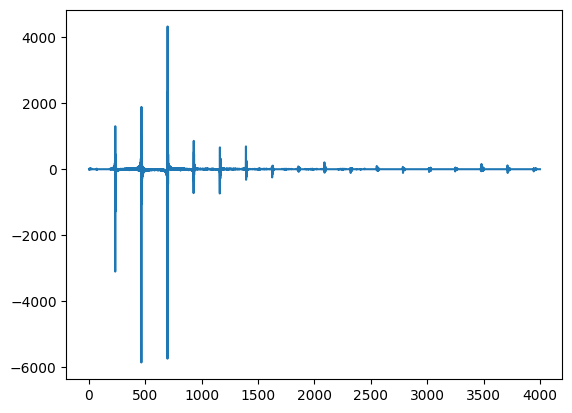

In [21]:
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

In [22]:
saxSegment2 = seg_dct.make_wave()
saxSegment2.make_audio()

При таком сжатии звук практически не отличается.

In [23]:
compress(seg_dct, thresh=30)
saxSegment3 = seg_dct.make_wave()
saxSegment3.make_audio()

21455	22050	97.3015873015873


При thresh=30 можно услышать, что звук начинает искажаться и терять часть звукового профиля.

<H3>Упражнение 6.3</H3>

В файле phase.ipynb исследуется как фаза влияет на восприятие звука. Возьмем другие сегменты тех же звуков и повторим эксперименты. Для этого воспользуемся несколькими функциями. Первая из них будет строить графики амплитуды, фазы и звуковой волны. Другие 3 функции делают следующие операции с углом фазы: изменят угол фаз на 0, добавят угол фазы и сделает угол случайным.

In [32]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    thinkdsp.decorate(xlabel='Frequency (Hz)', 
             ylabel='Phase (radian)')

In [33]:
def plot_three(spectrum, thresh=1):
    """Plot amplitude, phase, and waveform.
    
    spectrum: Spectrum object
    thresh: threshold passed to plot_angle
    """
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

In [34]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

In [35]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

In [36]:
PI2 = np.pi * 2

def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

Начнем с исследования пилообразного сигнала.

In [37]:
sawtoothSignal = thinkdsp.SawtoothSignal(freq=500, offset=0)
sawtoothWave = sawtoothSignal.make_wave(duration=0.5, framerate=40000)
sawtoothWave.make_audio()
sawtoothSpec = sawtoothWave.make_spectrum()

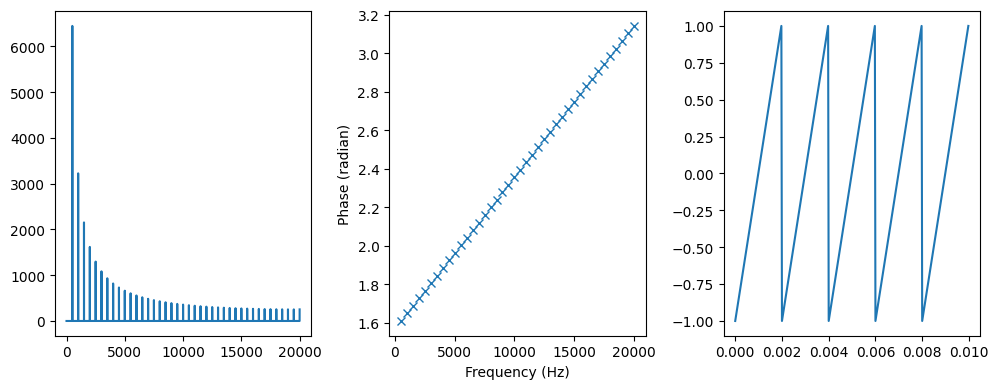

In [38]:
plot_three(sawtoothSpec)

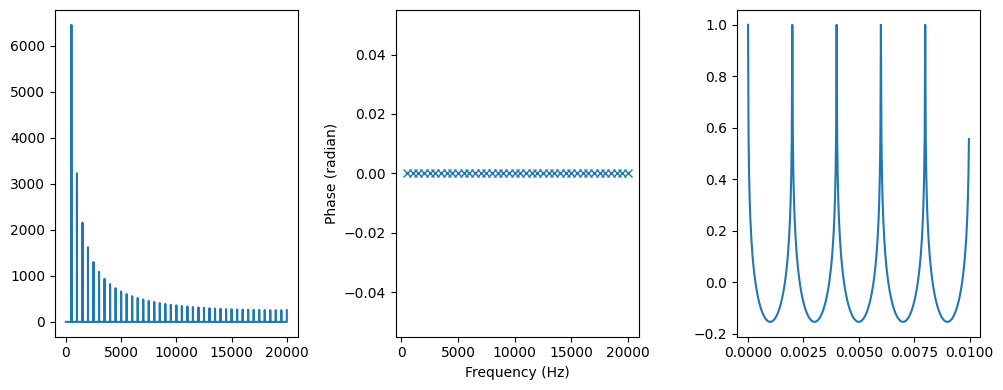

In [39]:
sawtoothSpec2 = zero_angle(sawtoothSpec)
plot_three(sawtoothSpec2)

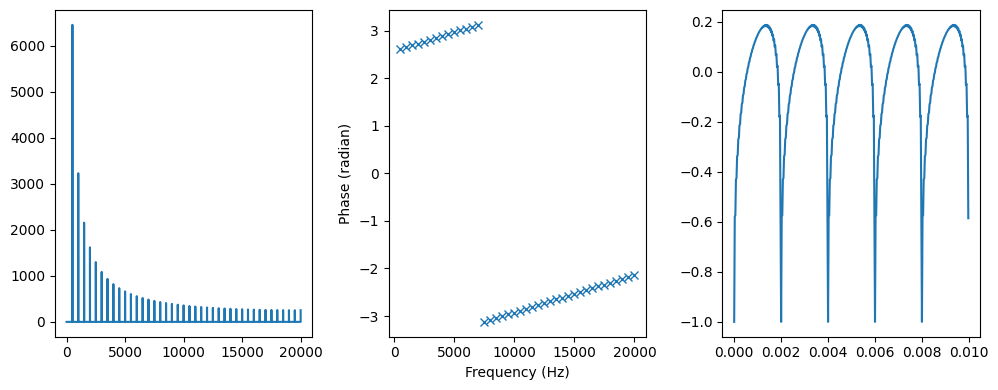

In [40]:
sawtoothSpec3 = rotate_angle(sawtoothSpec, 1)
plot_three(sawtoothSpec3)

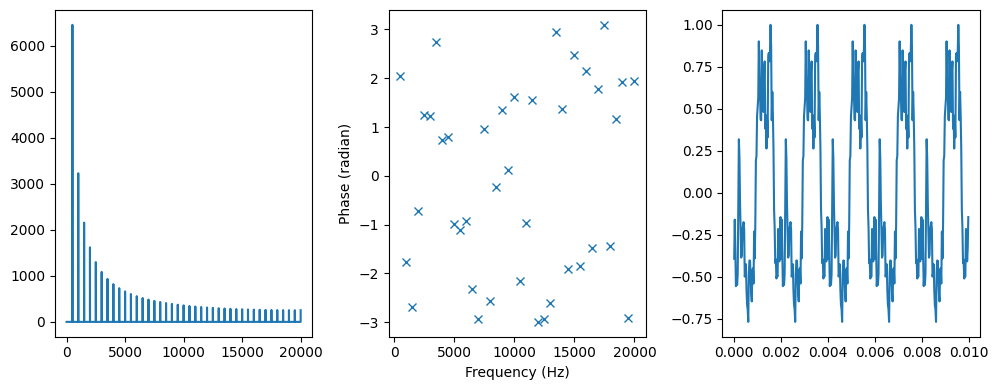

In [41]:
sawtoothSpec4 = random_angle(sawtoothSpec)
plot_three(sawtoothSpec4)

Как можно услышать изменений нет. Меняется только громкость сигнала, но это связано с нормализацией волны, а не с изменениями структуры.

Теперь посмотрим на другие, более естественные звуки. Для начала возьмем запись гобоя.

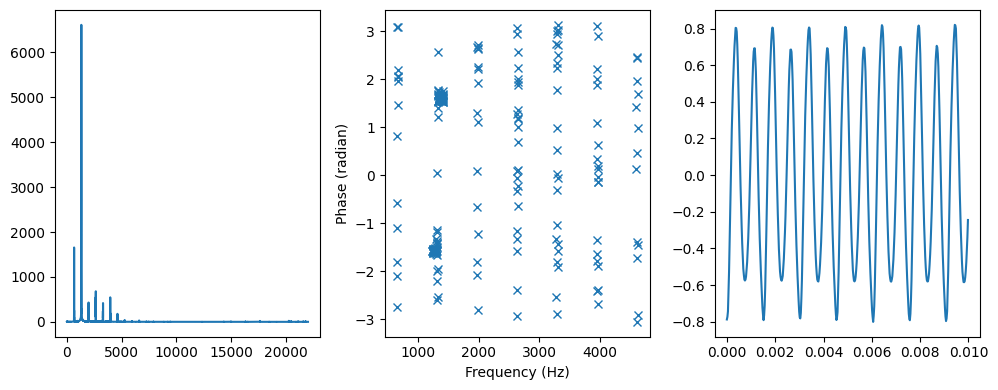

In [53]:
oboeWave = thinkdsp.read_wave('../code/120994__thirsk__120-oboe.wav')
oboeSegment = oboeWave.segment(start=2.3, duration=0.8)
oboeSpec = oboeSegment.make_spectrum()
plot_three(oboeSpec, thresh=50)

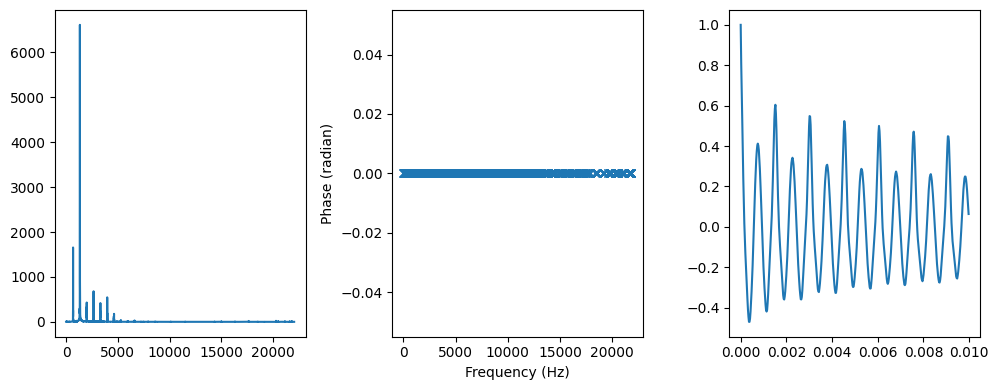

In [54]:
oboeSpec2 = zero_angle(oboeSpec)
plot_three(oboeSpec2)

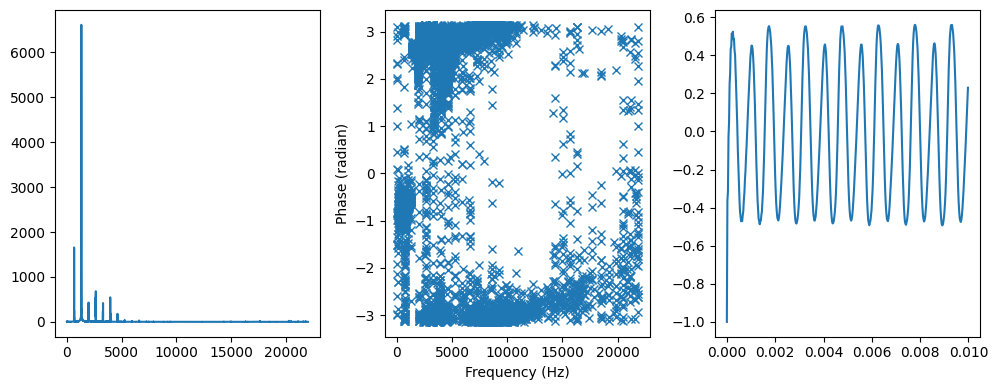

In [55]:
oboeSpec3 = rotate_angle(oboeSpec, 1)
plot_three(oboeSpec3)

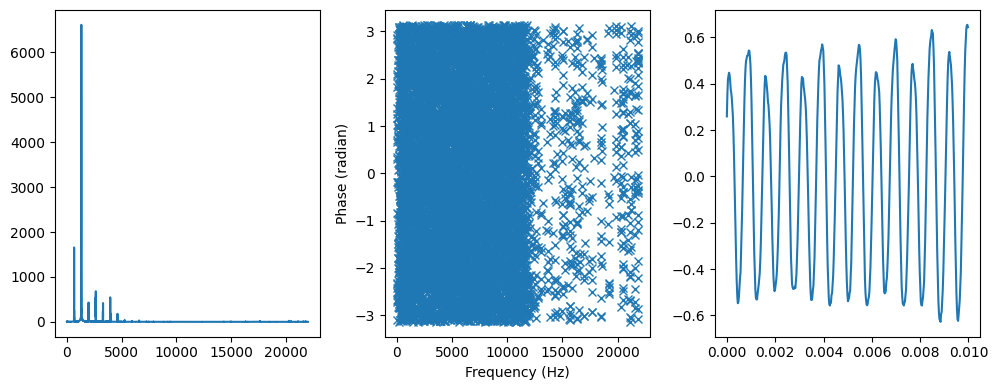

In [56]:
oboeSpec4 = random_angle(oboeSpec)
plot_three(oboeSpec4)

При углах равных нулю волна становится звонящей. Громкость звука варьируется во времени. Изменение угла не изменило волну, а установка случайных значений также делает волну звонящей и добавляет шум.

Теперь возьмем звук саксофона.

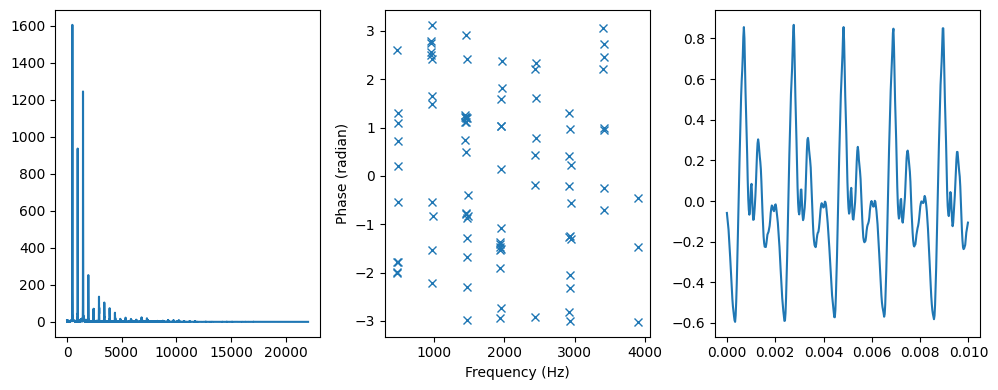

In [62]:
saxoWave = thinkdsp.read_wave('../code/100475__iluppai__saxophone-weep.wav')
saxoSegment = saxoWave.segment(start=2.8, duration=0.5)
saxoSpec = saxoSegment.make_spectrum()
plot_three(saxoSpec, thresh=50)

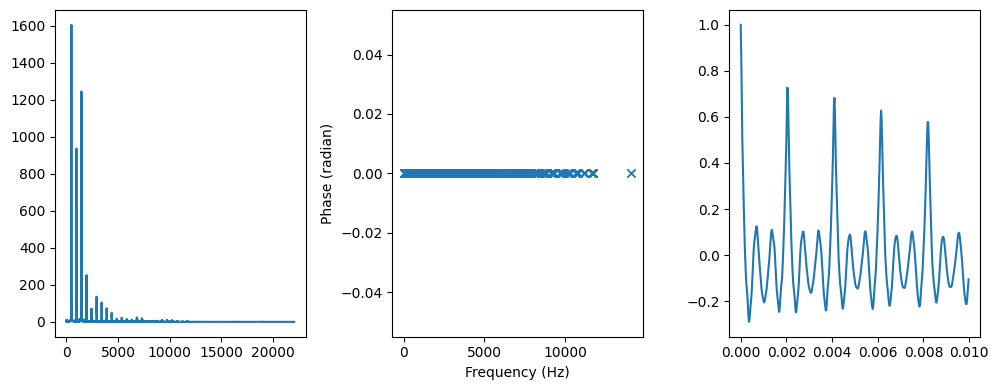

In [63]:
saxoSpec2 = zero_angle(saxoSpec)
plot_three(saxoSpec2)

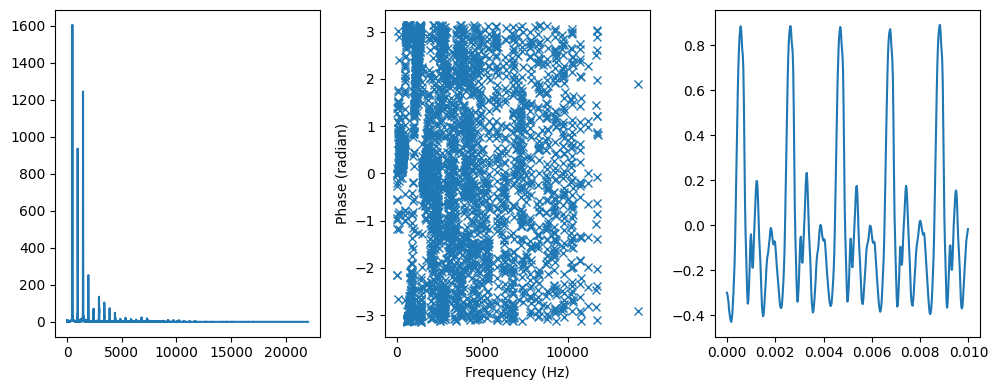

In [64]:
saxoSpec3 = rotate_angle(saxoSpec, 1)
plot_three(saxoSpec3)

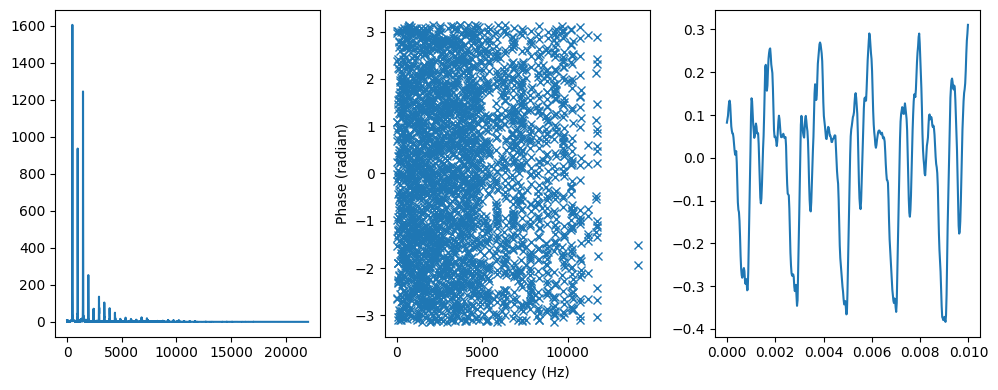

In [65]:
saxoSpec4 = random_angle(saxoSpec)
plot_three(saxoSpec4)

Результаты схожи с прошлыми результатами.

Таким образом, изменение фазы несильно изменяет свойства звука, которые мы слышим. Особенно когда дело касается звуков с гармонической структурой.